In [2]:
import math
import warnings

import numba
import numpy as np
import matplotlib.pyplot as plt

In this notebook we follow some algorithms from [[2007:random-matrices]](https://arxiv.org/pdf/math-ph/0609050v2.pdf) to generate random matrices. Random matrices are used in various benchmark functions as rotation matrices.
The referenced source is cited in the reference implementation [[2008:shark]](https://github.com/Shark-ML/Shark/blob/d0b28e623ec2d3cf4bcb5f0a7f0739a23cc7c7aa/include/shark/LinAlg/rotations.h).

Other links for some background:

* https://en.wikipedia.org/wiki/Unitary_group
* https://en.wikipedia.org/wiki/Unitary_matrix

An unitary matrix is the complex-valued analogue of a real-valued orthogonal matrix.

In [3]:
def verification_experiment(fn, rng, n=50, samples=10000):
    """Run an experiment (described in pp. 8-9) to plot the empirical eigenvalue density (a histogram)
    and the spacing distribution (a histogram as well)"""
    # Note: The Haar measure is the random matrix analogue to an uniform distribution
    #       The density of the eigenvalues should be uniform and equal to 1/2pi
    #       Furthermore, the distribution of the spacing distance 
    #       between the eigenvalues must fit the theoretical distribution.
    angles = np.zeros((samples, n))
    ss = np.zeros((samples, n-1))
    for i in range(samples):
        q = fn(n, rng)
        eig, _ = np.linalg.eig(q)
        angles[i, :] = np.sort(np.angle(eig))
        ss[i, :] = (n / (2. * np.pi)) * (angles[i, 1:] - angles[i, :-1])

    s_density, s_values = np.histogram(ss.flatten(), bins='auto', density=True)
    angle_density, angle_values = np.histogram(angles.flatten(), bins='auto', density=True)
    
    fig = plt.figure(figsize=(8, 4))
    axs = fig.subplots(1, 2)
    axs[0].plot(angle_values[:-1], angle_density, color='red', marker='x', linestyle='')
    axs[0].hlines(1. / (2. * np.pi), angle_values[0], angle_values[-1])
    axs[0].set_ylabel(r'$p(\theta)$')
    axs[0].set_xlabel(r'$\theta$')
    axs[0].set_ylim(0, 0.18)

    axs[1].plot(s_values[:-1], s_density, color='red', marker='x', linestyle='')
    # TODO: Find the theoretical definition of the spacing distribution to able to
    #       plot the reference against the empirical
    axs[1].set_ylabel(r'$p(s)$')
    axs[1].set_xlabel(r'$s$')
    
    return fig

# An incorrect random unitary matrix generator

In [4]:
def random_unitary_matrix_incorrect(n, rng):
    """Attempt (incorrectly) to generate a random unitary matrix with a distribution given
    by a Haar measure.
    
    Notes
    -----
    Introductory motivating example. See p.7 of [2007:random-matrices].
    """
    Z = (rng.standard_normal(size=(n,n)) + (1j * rng.standard_normal(size=(n,n)))) / np.sqrt(2.)
    Q , _ = np.linalg.qr(Z)
    return Q

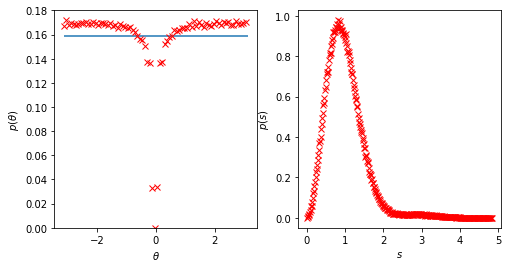

In [5]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_unitary_matrix_incorrect, rng, n=50, samples=10000)

In [27]:
def random_orthogonal_matrix_incorrect(n, rng):
    """The same but for orthogonal matrices."""
    Z = (rng.standard_normal(size=(n,n)) + (1j * rng.standard_normal(size=(n,n)))) / np.sqrt(2.)
    Q , _ = np.linalg.qr(Z)
    return Q

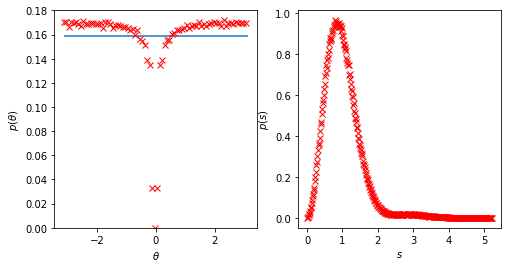

In [28]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_orthogonal_matrix_incorrect, rng, n=50, samples=10000)

# A correct random unitary matrix generator

In [6]:
def random_unitary_matrix(n, rng):
    """Generate a random unitary matrix with a distribution given by a Haar measure.
    
    Notes
    -----
    See pp. 11-12 of [2007:random-matrices]
    """
    Z = (rng.standard_normal(size=(n,n)) + (1j * rng.standard_normal(size=(n,n)))) / np.sqrt(2.)
    return random_unitary_matrix_jit(n, Z)

@numba.jit
def random_unitary_matrix_jit(n, Z):
    Q , r = np.linalg.qr(Z)
    d = np.diag(r)
    return Q * (d / np.abs(d)) @ Q

def random_unitary_matrix_nojit(n, rng):
    Z = (rng.standard_normal(size=(n,n)) + (1j * rng.standard_normal(size=(n,n)))) / np.sqrt(2.)
    Q , r = np.linalg.qr(Z)
    d = np.diag(r)
    return Q * (d / np.abs(d)) @ Q

In [7]:
# Numba complains about matrix multiplication
# (...) NumbaPerformanceWarning: '@' is faster on contiguous arrays (...)
warnings.filterwarnings("ignore", category=numba.NumbaPerformanceWarning)

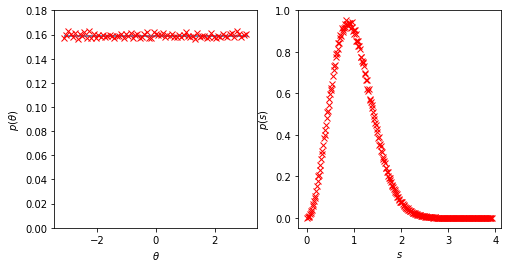

In [8]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_unitary_matrix, rng, n=50, samples=10000)

# The previous algorithm but for random orthogonal matrices

In [9]:
def random_orthogonal_matrix_sign_correction(n, rng):
    """Generate a random orthogonal matrix with a distribution given by a Haar measure.
    
    Notes
    -----
    See pp. 11-12 of [2007:random-matrices]
    """
    Z = rng.standard_normal(size=(n,n))
    return random_orthogonal_matrix_sign_correction_jit(n, Z)

@numba.jit
def random_orthogonal_matrix_sign_correction_jit(n, Z):
    Q , r = np.linalg.qr(Z)
    d = np.diag(r)
    return Q * (d / np.abs(d)) @ Q

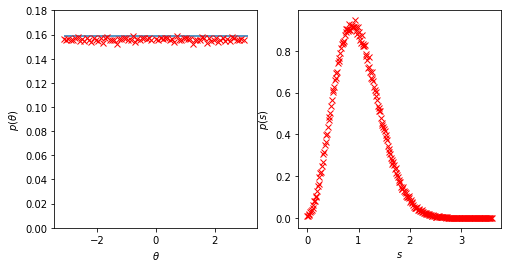

In [10]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_orthogonal_matrix_sign_correction, rng, n=50, samples=10000)

In [11]:
def random_orthogonal_matrix_sign_correction_nojit(n, rng):
    Z = rng.standard_normal(size=(n,n))
    Q , r = np.linalg.qr(Z)
    d = np.diag(r)
    return Q * (d / np.abs(d)) @ Q

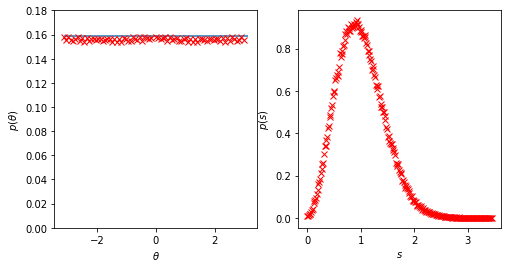

In [12]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_orthogonal_matrix_sign_correction_nojit, rng, n=50, samples=10000)

# Random orthogonal matrix generation for ZDT4'
Rotation matrices for the ZDT4' function have the restriction that they must not rotate the first coordinate of the point. Here we run the verification experiment on these matrices.

In [32]:
def random_orthogonal_matrix_zdt4(n, rng):
    """Generate a random orthogonal matrix for the ZDT4' function.
    
    Notes
    -----
    See pp. 15-16 of [2007:mo-ma-cma]
    """
    Q = np.zeros((n, n))
    Q[0, 0] = 1.
    Q[1:, 1:] = random_orthogonal_matrix_sign_correction(n-1, rng)
    return Q

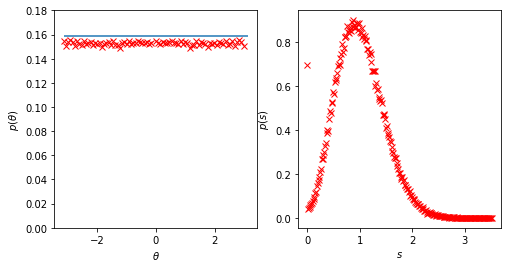

In [34]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_orthogonal_matrix_zdt4, rng, n=50, samples=10000)

There is a subtle difference with the expected results, but otherwise looks good.

# An alternative algorithm for random orthogonal matrices

For the next algorithm, we need to build $$Q = H_n^T(\hat{v}_n) \tilde{H}^T_{n-1}(\hat{v}_{n-1}) \cdots \tilde{H}^T_{2}(\hat{v}_2) \tilde{H}^T_{1}(\hat{v}_1)$$.
 
Where $$\tilde{H}_{m} = \left( \begin{matrix} I_{n-m} & \, \\ \, & H_{m} \end{matrix} \right)$$
      $$H_m(\hat{v}) = \begin{cases}
                         -\text{sgn}(x_1) \left( I - 2 \hat{u} \hat{u}^T \right) & \hat{v} \neq e_1 \\
                         I_m & \hat{v} = e_1
                       \end{cases}
      $$
      $$\hat{u} = \frac{\hat{v} + \text{sgn}(x_1)e_1}{|| \hat{v} + \text{sgn}(x_1) e_1 ||}$$
      $$\hat{v} = \frac{v}{||v||}$$
      $$\text{sgn}(x) = \frac{x}{|x|} = \frac{|x|}{x}$$
      $$ m = 1 \cdots n$$

In [13]:
def random_orthogonal_matrix_alternative(n, rng):
    """Generate a random orthogonal matrix with distribution given by a Haar measure.
    
    Notes
    -----
    This algorithm is the one used in [2008:shark] because it is faster, we port the implementation here.
    See p. 16 from [2007:random-matrices]

    The benchmark functions (e.g. CIGTAB1) require an orthogonal rotation matrix [2007:mo-cma-es].
    """
    v = rng.standard_normal((n * n + n - 2) // 2)
    return random_orthogonal_matrix_alternative_jit(n, v)

@numba.njit
def random_orthogonal_matrix_alternative_jit(n: int, v: np.ndarray) -> np.ndarray:
    Q = np.eye(n)
    k = 0
    # We can safely skip the first iteration
    for i in range(2, n + 1):
        # Compute v_hat
        ki = k + i
        ni = n - i
        v[k:ki] /= np.linalg.norm(v[k:ki])
        # Compute u_hat
        sgn = v[k] / abs(v[k])
        v[k] += sgn
        tmp = v[k:ki]
        beta = 2.0 / np.sum(tmp * tmp)
        # Apply the Householder reflection
        Q[ni:n, ni:n] -= beta * np.outer(tmp, Q[ni:n, ni:n].T @ tmp)
        Q[ni:n, ni:n] *= -sgn
        k += i
    return Q

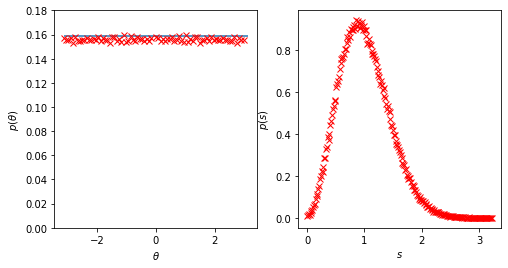

In [14]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_orthogonal_matrix_alternative, rng, n=50, samples=10000)

# Measuring performance

In [15]:
rng = np.random.default_rng(None)
n = 10

In [16]:
%timeit random_orthogonal_matrix_sign_correction(n, rng)

14.7 µs ± 642 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
%timeit random_orthogonal_matrix_sign_correction_nojit(n, rng)

135 µs ± 7.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit random_orthogonal_matrix_alternative(n, rng)

23 µs ± 627 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
n = 100

In [20]:
%timeit random_orthogonal_matrix_sign_correction(n, rng)

1.62 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
%timeit random_orthogonal_matrix_sign_correction_nojit(n, rng)

1.26 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%timeit random_orthogonal_matrix_alternative(n, rng)

2.43 ms ± 45.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
n = 1000

In [24]:
%timeit random_orthogonal_matrix_sign_correction(n, rng)

554 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit random_orthogonal_matrix_sign_correction_nojit(n, rng)

411 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit random_orthogonal_matrix_alternative(n, rng)

3.81 s ± 365 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Conclusions

Our implementation of the alternative algorithm does not perform better than the implementation of the first algorithm.
This could be because are using matrix multiplication with non-contiguous arrays, as Numba suggested. This happens because we slice in the second dimension when selecting submatrices.